In [1]:
# Phase 3 – Predictive Modeling in Google Colab
# Works with Project_Data_FinalV.csv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

from google.colab import files


In [3]:
# Upload Project_Data_FinalV.csv from your computer

uploaded = files.upload()  # choose Project_Data_FinalV.csv in the dialog

# Get the filename (first file uploaded)
filename = list(uploaded.keys())[0]
print("Loaded file:", filename)

df = pd.read_csv(filename)
df.head()


Saving Project_Data_FinalV.csv to Project_Data_FinalV.csv
Loaded file: Project_Data_FinalV.csv


,API_COMPANY,API_VENDOR_ID,API_INVOICE_ID,API_INV_CURRENCY,API_DISCOUNT_DATE,API_INVOICE_DATE,API_PO_NUMBER,API_PO_CODE,API_DESCRIPTION,API_BASE_INV_AMT,...,Job_Description,Salary,First_Name,Last_Name,Country_Code,Day_of_Week,Flag_Weekend,Flag_Self_Approval,Flag_High_Value,Transaction_Legality
0,LAX,3542,594328384,USD,2/16/2024,2/16/2024,23759,REG,No Description Provided,194.89,...,OPERATOR,26250,WILLIAM,WILSON,US,4,0,0,0,Legal
1,LAX,2881,1000037656,USD,2/11/2024,2/11/2024,23763,REG,No Description Provided,426418.31,...,MANAGER,36170,RICHARD,TAKVORIAN II,US,6,1,0,1,Illegal
2,LAX,348,105-0157-001,USD,1/7/2024,1/7/2024,23760,REG,No Description Provided,348.23,...,MANAGER,38250,GREGORY,QUINLAN,US,0,0,0,0,Legal
3,MIA,901000,MKN0004,USD,2/17/2024,2/17/2024,23771,REG,No Description Provided,15407.27,...,FIELDREP,25370,VINCENT,SCARPETTA,US,0,0,0,0,Legal
4,LAX,3144,233745635,USD,3/13/2024,3/13/2024,23770,REG,No Description Provided,43.91,...,DESIGNER,18270,DAVID,LAUER,US,2,0,0,0,Legal


In [4]:
def build_features(df: pd.DataFrame):
    # --- Invoice amount ---
    if "API_BASE_INV_AMT" not in df.columns:
        raise KeyError("Expected column 'API_BASE_INV_AMT' not found.")
    df["API_BASE_INV_AMT"] = pd.to_numeric(df["API_BASE_INV_AMT"], errors="coerce")

    # --- Day_of_Week (already in file or derived from API_CREATE_DATE) ---
    if "Day_of_Week" not in df.columns:
        if "API_CREATE_DATE" not in df.columns:
            raise KeyError("Expected 'Day_of_Week' or 'API_CREATE_DATE' not found.")
        df["API_CREATE_DATE"] = pd.to_datetime(df["API_CREATE_DATE"], errors="coerce")
        df["Day_of_Week"] = df["API_CREATE_DATE"].dt.dayofweek

    # --- Department_ID from Work_Dept_ ---
    if "Work_Dept_" not in df.columns:
        raise KeyError("Expected column 'Work_Dept_' not found.")
    df["Work_Dept_"] = df["Work_Dept_"].astype(str)
    df["Department_ID"] = df["Work_Dept_"].astype("category").cat.codes

    # --- Salary_Ratio = Invoice / Salary ---
    if "Salary" not in df.columns:
        raise KeyError("Expected column 'Salary' not found.")
    df["Salary"] = pd.to_numeric(df["Salary"], errors="coerce")

    df["Salary_Ratio"] = df["API_BASE_INV_AMT"] / df["Salary"].replace(0, np.nan)
    df["Salary_Ratio"] = df["Salary_Ratio"].replace([np.inf, -np.inf], np.nan)

    # Final feature set
    feature_cols = ["API_BASE_INV_AMT", "Day_of_Week", "Department_ID", "Salary_Ratio"]
    X = df[feature_cols].copy().fillna(0)

    # Target
    if "Transaction_Legality" not in df.columns:
        raise KeyError("Expected column 'Transaction_Legality' not found.")

    y = df["Transaction_Legality"].map({"Legal": 0, "Illegal": 1})
    mask = y.notna()
    X = X[mask]
    y = y[mask].astype(int)

    return X, y, feature_cols

X, y, feature_cols = build_features(df)
X.head()


,API_BASE_INV_AMT,Day_of_Week,Department_ID,Salary_Ratio
0,194.89,4,4,0.007424
1,426418.31,6,3,11.789281
2,348.23,0,1,0.009104
3,15407.27,0,5,0.607303
4,43.91,2,2,0.002403


In [5]:
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    # Show numbers in cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    fig.tight_layout()
    plt.show()


def plot_feature_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_names = [feature_names[i] for i in indices]

    fig, ax = plt.subplots()
    ax.bar(range(len(sorted_importances)), sorted_importances)
    ax.set_xticks(range(len(sorted_importances)))
    ax.set_xticklabels(sorted_names, rotation=45, ha="right")
    ax.set_ylabel("Importance")
    ax.set_title("Feature Importance")
    fig.tight_layout()
    plt.show()


Training model...
Predicting on test set...

=== Accuracy ===
Accuracy: 1.0000

=== Confusion Matrix (rows = true, cols = predicted) ===
[[3637    0]
 [   0   16]]

=== Classification Report ===
              precision    recall  f1-score   support

       Legal       1.00      1.00      1.00      3637
     Illegal       1.00      1.00      1.00        16

    accuracy                           1.00      3653
   macro avg       1.00      1.00      1.00      3653
weighted avg       1.00      1.00      1.00      3653



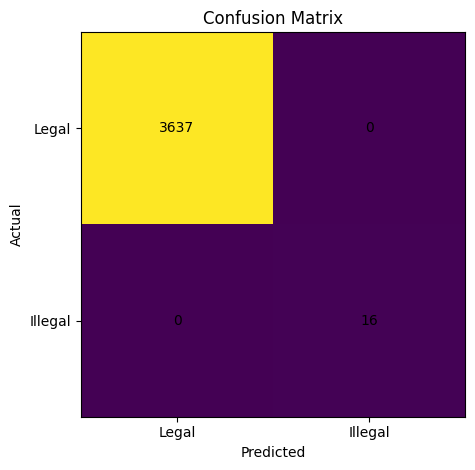


=== Feature Importance ===
API_BASE_INV_AMT      0.5754
Day_of_Week           0.1040
Department_ID         0.0017
Salary_Ratio          0.3190


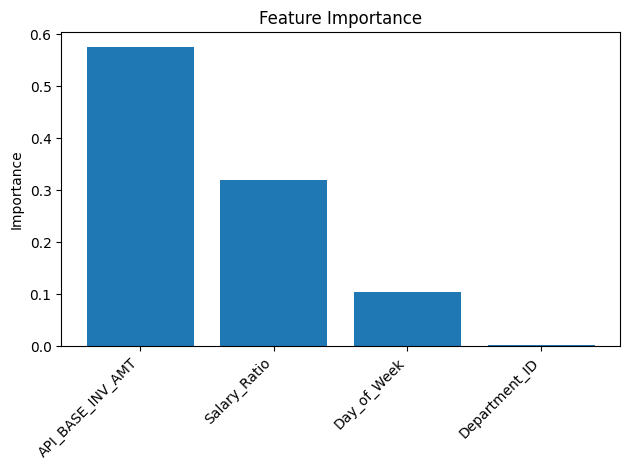

In [6]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

print("Training model...")
clf.fit(X_train, y_train)

print("Predicting on test set...")
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("\n=== Accuracy ===")
print(f"Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n=== Confusion Matrix (rows = true, cols = predicted) ===")
print(cm)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Legal", "Illegal"]))

# Plots
plot_confusion_matrix(cm, ["Legal", "Illegal"])

importances = clf.feature_importances_
print("\n=== Feature Importance ===")
for feat, val in zip(feature_cols, importances):
    print(f"{feat:20s}  {val:.4f}")

plot_feature_importance(importances, feature_cols)


In [7]:
# Optional: add predictions back to the original dataframe and download

df_model = df.copy()
df_model = df_model.iloc[y.index].copy()  # align indices with X,y
df_model["Predicted_Legality"] = np.where(clf.predict(X) == 1, "Illegal", "Legal")

output_name = "Project_Data_FinalV_with_predictions.csv"
df_model.to_csv(output_name, index=False)
print("Saved:", output_name)

files.download(output_name)


Saved: Project_Data_FinalV_with_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>